# MAXIS全世界株式（オール・カントリー） (2559) ETF vs eMAXIS Slim 全世界株式（オール・カントリー） Mutual Fund

MUFG All Country ETF vs eMAXIS Slim All Country mutual fund: which has performed best?

Code to download price data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

def url_to_df(url):
    return pd.read_csv(url, encoding='cp932', skiprows = 2, parse_dates = [0], index_col = [0],
                      names=['date', 'price', 'price_div_reinv', 'div', 'assets'])

etf_url = 'https://maxis.mukam.jp/content/csv/fundCsv.php?fund_cd=182559' # link from https://maxis.mukam.jp/etf_fund/182559.html
mutual_url = 'https://emaxis.jp/content/csv/fundCsv.php?fund_cd=253425' # link from https://emaxis.jp/fund/253425.html

ind = 'MSCI_ACWI'

etf = url_to_df(etf_url)
mutual = url_to_df(mutual_url)

start_date = etf.index.min()
mutual = mutual[mutual.index >= start_date] # match date range of mutual data to ETF data
mutual.to_csv('mutual_' + ind + '.csv', index=True)

# Spreadsheet data downloaded from https://www.msci.com/end-of-day-data-search then processed manually into TSV file
file = 'MSCI_ACWI_Standard_Large_Mid_Cap.tsv'
benchmark_tr = pd.read_csv(file, sep='\t', index_col='Date', parse_dates=True)
benchmark_tr = benchmark_tr[benchmark_tr.index >= start_date] 

# Daily USDJPY FX rates used to rebased the USD-based index to JPY
usdjpy = yf.Ticker('JPY=X').history(start=str(start_date).split()[0])
usdjpy = usdjpy[usdjpy.index.isin(benchmark_tr.index)] # cut down data to match dates in benchmark

# Create columns with the JPY-based benchmark indices
benchmark_tr['Gross_jpy'] = usdjpy['Close'] * benchmark_tr['Gross']
benchmark_tr['Net_jpy'] = usdjpy['Close'] * benchmark_tr['Net']

benchmark_tr.to_csv('benchmark_tr_' + ind + '.csv', index=True)

Create a dividends table for the ETF. Add dividend pay dates, foreign tax data, and calculate net dividends (net of foreign tax and domestic tax, with foreign tax credit claimed).

In [2]:
jp_income_tax_rate = 0.15315
jp_inhabitant_tax_rate = 0.05

dividends = etf[etf['div'].notna()]['div'].copy().to_frame()
dividends['pay_date'] = pd.to_datetime(['2020-07-17', '2021-01-15'])
# couldn't find foreign tax rate for first dividend, so using the second dividend rate to approximate it
# second dividend foreign tax rate source: https://mrmarket-japan.com/tousihoka/etf-toushin-double-taxation/
dividends['foreign_tax_rate'] = [0.1008127489, 0.1008127489]
dividends['net_div'] = (dividends['div'] * (dividends['foreign_tax_rate']+1) * 
                        (1-jp_income_tax_rate-jp_inhabitant_tax_rate))
dividends.head()

,div,pay_date,foreign_tax_rate,net_div
date,,,,
2020-06-08,39.0,2020-07-17,0.100813,34.210123
2020-12-08,64.0,2021-01-15,0.100813,56.139689


Calculate growth of net dividends reinvested on pay date.

In [3]:
for i, (_, row) in enumerate(dividends.iterrows()):
    etf['div_'+str(i)] = 0.0
    div = row['net_div']
    pay_date = row['pay_date']
    buy_price =  etf.loc[pay_date, 'price'] 
    etf.loc[etf.index >= pay_date, 'div_'+str(i)] = div*etf.loc[etf.index >= pay_date, 'price']/buy_price

etf.to_csv('etf_' + ind + '.csv', index=True)

Create function to calculate the return of the ETF based on lump sum investment on chosen date, subsequently reinvesting the net dividends on pay date.

In [4]:
def etf_return(df, date):
    date = pd.to_datetime(date)
    investment = df['price'].copy()
    for i, index in enumerate(dividends.index):
        if date > index:
            continue
        investment += df['div_'+str(i)]
        
    return investment

Function to return a data series of prices normalized to a chosen date.

In [5]:
def normlize_to_date(series, date):
    return (series/series.loc[date]).copy()

Calculate the growths of the mutual and the ETF funds, and their difference, based on initial investment on date.

In [6]:
def grow(mutual, etf, date):
    date = pd.to_datetime(date)

    mutual_growth = normlize_to_date(mutual['price'], date)
    etf_growth = normlize_to_date(etf_return(etf, date), date)

    growth_difference = (mutual_growth - etf_growth)*100
    
    return mutual_growth, etf_growth, growth_difference

Plot the results and save the figure:

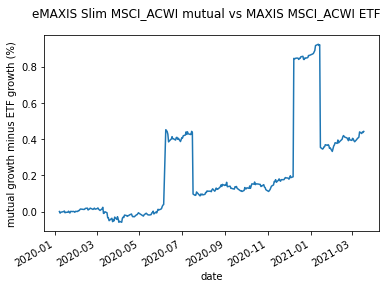

In [7]:
date = '2020-01-08'
mutual_growth, etf_growth, growth_difference = grow(mutual, etf, date)

ax = growth_difference.plot()
ax.set_ylabel('mutual growth minus ETF growth (%)')
fig = plt.gcf()
fig.suptitle('eMAXIS Slim ' + ind + ' mutual vs MAXIS ' + ind + ' ETF')
fig.savefig('slim_vs_2559_growth.png', dpi=100)

Plot the performance of the funds against the benchmark index:

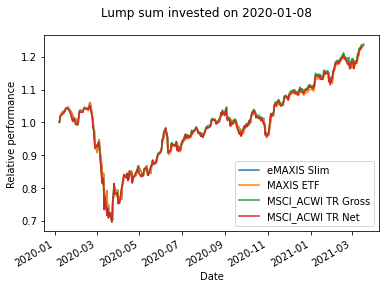

In [8]:
ax = mutual_growth.plot(label='eMAXIS Slim')
etf_growth.plot(ax=ax, label='MAXIS ETF')
normlize_to_date(benchmark_tr['Gross_jpy'], date).plot(ax=ax, label=ind + ' TR Gross')
normlize_to_date(benchmark_tr['Net_jpy'], date).plot(ax=ax, label=ind + ' TR Net')
ax.legend()
ax.set_ylabel('Relative performance')
fig = plt.gcf()
fig.suptitle('Lump sum invested on ' + date)
fig.savefig('slim_vs_2559_benchmark.png', dpi=100)

Some checks of the annual growth figures for the year running from the end of January 2020 against numbers from last graph on https://shintaro-money.com/maxis-ac-2559/:

In [9]:
start_date = '2020-01-31'
end_date = '2021-01-29'

# ETF paying Japan taxes on dividends (with foreign tax credit)
((etf.loc[end_date, 'price']
  +etf.loc[end_date, 'div_0']
  +etf.loc[end_date, 'div_1'])
 /etf.loc[start_date, 'price'])

1.1219298417422474

In [10]:
# ETF assuming no Japan taxes on dividends
etf.loc[end_date, 'price_div_reinv']/etf.loc[start_date, 'price_div_reinv']

1.1234555599840574

In [11]:
# Mutual fund
mutual.loc[end_date, 'price']/mutual.loc[start_date, 'price']

1.1253964172452215

In [12]:
# Benchmark total returns index (gross)
benchmark_tr.loc[end_date, 'Gross_jpy']/benchmark_tr.loc[start_date, 'Gross_jpy']

1.1263710986496047

In [13]:
# Benchmark total returns index (gross)
benchmark_tr.loc[end_date, 'Net_jpy']/benchmark_tr.loc[start_date, 'Net_jpy']

1.1208992695518525

These middle two numbers agree with the numbers from the final 騰落率 vs 実質コスト graph on the Shintaro website. The final number two numbers (ACWI TR Gross and Net) are a little off compared to Shintaro money, but still reasonable.

Conclusion: the ETF lagged the mutual by about 0.29% for the one year period from the end of January 2020, i.e. slightly more than the 0.1% reported on the Shintaro website. 